# Disclaimer

This can only properly be run on a heavy duty PC

In [1]:
training_rows_to_read = 100000 # This needs to be 15000000

# Imports

In [21]:
from ebay_delivery_prediction_project import preprocessing, Visualisation, preprocessing_models, postprocessing
preprocessing.import_test()

from datetime import datetime, timedelta
import numpy as np
import pandas as pd

Preprocessing successfully imported.


In [3]:
# data_object = Preprocessing.read_data(rows_to_read = None, columns = ["b2c_c2c"])
# data_object = Preprocessing.read_data(rows_to_read = None)
training_data = preprocessing.read_data(rows_to_read = training_rows_to_read)["train"]
print(training_data.columns)

Reading 100000 rows.
Reading all columns.
Index(['b2c_c2c', 'seller_id', 'declared_handling_days',
       'acceptance_scan_timestamp', 'shipment_method_id', 'shipping_fee',
       'carrier_min_estimate', 'carrier_max_estimate', 'item_zip', 'buyer_zip',
       'category_id', 'item_price', 'quantity', 'payment_datetime',
       'delivery_date', 'weight', 'weight_units', 'package_size',
       'record_number'],
      dtype='object')


# Setting up pipeline

## Target column

The objective is to estimate the total number of calendar days (after payment) it will take to have a purchased item show up at the buyer’s address. This is equivalent to estimating the delivery date using the formula:

payment date (local time) + delivery calendar days = delivery date (local time).

Participants should provide this delivery date in their submissions.

_Now to generate target column_

### Run the basic preprocessing steps

In [4]:
training_data = preprocessing.basic_preprocessing(training_data)

Finished parse_datetime_columns
Finished create_delivery_calendar_days
Finished clean_zip_codes


In [5]:
training_data["delivery_calendar_days"].describe()

count    100000.000000
mean          4.760280
std           3.067802
min           0.000000
25%           3.000000
50%           4.000000
75%           5.000000
max         101.000000
Name: delivery_calendar_days, dtype: float64

In [6]:
for col in training_data.columns:
    print(f"{col} : {len(training_data[col].unique())}")

b2c_c2c : 2
seller_id : 57971
declared_handling_days : 11
acceptance_scan_timestamp : 88902
shipment_method_id : 17
shipping_fee : 1700
carrier_min_estimate : 6
carrier_max_estimate : 6
item_zip : 16089
buyer_zip : 19592
category_id : 33
item_price : 6518
quantity : 28
payment_datetime : 99878
delivery_date : 667
weight : 318
weight_units : 1
package_size : 5
record_number : 100000
delivery_calendar_days : 82
cleaned_item_zip : 15432
cleaned_buyer_zip : 19454
distance_between_pincodes : 98194


# Saving and loading preprocessed data

In [1]:
training_data.shape

NameError: name 'training_data' is not defined

In [ ]:
training_data.to_csv("../data/preprocessed_data/preprocessed_data.csv", index = False)

# Start running from here if no extra preprocessing

In [2]:
training_data = pd.read_csv("../data/preprocessed_data/preprocessed_data.csv")

NameError: name 'pd' is not defined

In [ ]:
training_data.shape

# Implementing pipeline

## Arbitrarily choosing how to encode columns

In [7]:
different_types_of_encoding = ["one-hot", "numerical"]

cols_and_encoding = {
    "b2c_c2c"   : "one-hot",
    "seller_id"   : 6365,
    "declared_handling_days"   : "numerical",
    "acceptance_scan_timestamp"   : 9848,
    "shipment_method_id"   : "one-hot",
    "shipping_fee"   : "numerical",
    "carrier_min_estimate"   : 4, # Cheating?
    "carrier_max_estimate"   : 5, # Cheating?
    "item_zip"   : 4701, # Needs a lot of preprocessing.
    "buyer_zip"   : 6880, # Needs a lot of preprocessing.
    "category_id"   : 'one-hot', # Only has 33 unique values in 15,000,000 rows so one-hot.
    "item_price"   : "numerical",
    "quantity"   : "numerical",
    "payment_datetime"   : 9998,
    "delivery_date"   : 602,
    "weight"   : "numerical",
    "weight_units"   : 1,
    "package_size"   : "one-hot",
    "record_number"   : 10000,
    "delivery_calendar_days"   : "target",
    "cleaned_item_zip" : 30743,
    "cleaned_buyer_zip" : 34876,
    "distance_between_pincodes" : "numerical",
}

In [8]:
cols_to_convert_to_one_hot = [ele for ele in cols_and_encoding.keys() if cols_and_encoding[ele] == "one-hot"]

print("cols_to_convert_to_one_hot : ", cols_to_convert_to_one_hot)

print("training_data.shape before : ", training_data.shape)
training_data, generated_columns = preprocessing.one_hot_encode_columns(df = training_data, columns = cols_to_convert_to_one_hot)
print("training_data.shape after : ", training_data.shape)

cols_to_convert_to_one_hot :  ['b2c_c2c', 'shipment_method_id', 'category_id', 'package_size']
training_data.shape before :  (100000, 23)
training_data.shape after :  (100000, 76)


In [9]:
target_column = "delivery_calendar_days"
cols_to_use = [ele for ele in cols_and_encoding.keys() if (type(cols_and_encoding[ele]) == str) and
               (cols_and_encoding[ele] != "target") and
               (cols_and_encoding[ele] != "one-hot")]
cols_to_use = [*cols_to_use, *generated_columns]

## Running a gradient boosted decision tree model

In [10]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn import metrics

### Custom evaluation function

In [22]:
def customLossFunctionEval(y_true, y_pred):
    residual = (y_true - y_pred).astype(np.float32)
    loss = np.where(residual < 0, 0.4 * (residual ** 2), 0.6 * (residual ** 2))
    return "Custom Loss Function", np.mean(loss), False

In [23]:
# To define the input and output feature
# x = training_data.drop(['Embarked','PassengerId'],axis=1)
x = training_data[cols_to_use]
y = training_data[target_column]
# train and test split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.33,random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((67000, 63), (33000, 63), (67000,), (33000,))

In [24]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=[(x_test,y_test),(x_train,y_train)],
          verbose=10,eval_metric=customLossFunctionEval)# This loss needs to mirror the loss that Ebay is using.

[10]	training's l2: 8.46691	training's Custom Loss Function: 4.79781	valid_0's l2: 7.58238	valid_0's Custom Loss Function: 4.26384
[20]	training's l2: 8.12338	training's Custom Loss Function: 4.5864	valid_0's l2: 7.44383	valid_0's Custom Loss Function: 4.16879
[30]	training's l2: 7.9497	training's Custom Loss Function: 4.47916	valid_0's l2: 7.43549	valid_0's Custom Loss Function: 4.15501
[40]	training's l2: 7.82296	training's Custom Loss Function: 4.40198	valid_0's l2: 7.43151	valid_0's Custom Loss Function: 4.14635
[50]	training's l2: 7.71789	training's Custom Loss Function: 4.33901	valid_0's l2: 7.42744	valid_0's Custom Loss Function: 4.14018
[60]	training's l2: 7.6491	training's Custom Loss Function: 4.29848	valid_0's l2: 7.43303	valid_0's Custom Loss Function: 4.14214
[70]	training's l2: 7.58942	training's Custom Loss Function: 4.26348	valid_0's l2: 7.44	valid_0's Custom Loss Function: 4.14461
[80]	training's l2: 7.53288	training's Custom Loss Function: 4.23028	valid_0's l2: 7.4446

LGBMRegressor(max_depth=-5, random_state=42)

In [25]:
model = lgb.LGBMRegressor(learning_rate=0.1,max_depth=-5,random_state=42)
model.fit(x_train,y_train,eval_set=(x_test,y_test),
          verbose=10,eval_metric=customLossFunctionEval)# This loss needs to mirror the loss that Ebay is using.

[10]	valid_0's l2: 7.58238	valid_0's Custom Loss Function: 4.26384
[20]	valid_0's l2: 7.44383	valid_0's Custom Loss Function: 4.16879
[30]	valid_0's l2: 7.43549	valid_0's Custom Loss Function: 4.15501
[40]	valid_0's l2: 7.43151	valid_0's Custom Loss Function: 4.14635
[50]	valid_0's l2: 7.42744	valid_0's Custom Loss Function: 4.14018
[60]	valid_0's l2: 7.43303	valid_0's Custom Loss Function: 4.14214
[70]	valid_0's l2: 7.44	valid_0's Custom Loss Function: 4.14461
[80]	valid_0's l2: 7.44461	valid_0's Custom Loss Function: 4.14668
[90]	valid_0's l2: 7.45308	valid_0's Custom Loss Function: 4.15117
[100]	valid_0's l2: 7.45713	valid_0's Custom Loss Function: 4.15202


LGBMRegressor(max_depth=-5, random_state=42)

In [26]:
model_test_outputs = model.predict(x_test)

In [29]:
pd.Series(model_test_outputs).describe()

count    33000.000000
mean         4.766630
std          1.184391
min          2.285125
25%          4.218357
50%          4.497487
75%          4.989303
max         39.968843
dtype: float64

In [27]:
len(model_test_outputs)

33000

In [31]:
model_test_outputs

array([4.48987502, 4.10864026, 5.01829158, ..., 5.62991368, 4.34963524,
       4.14027315])

In [30]:
y_test

75721     5
80184     3
19864     5
76699    10
92991     7
         ..
97545     3
15490     4
62384     5
54594     3
64709     4
Name: delivery_calendar_days, Length: 33000, dtype: int64

In [32]:
customLossFunctionEval(y_true = y_test, y_pred = model_test_outputs)

('Custom Loss Function', 4.1520176, False)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

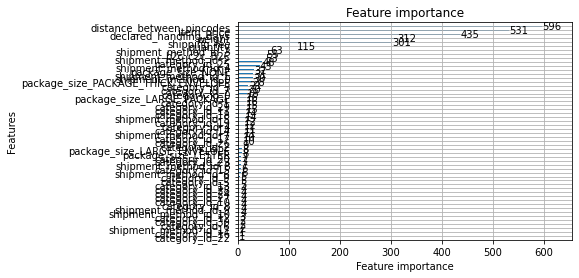

In [13]:
lgb.plot_importance(model)

In [14]:
feature_importances = {}

for importance, feature in zip(model.feature_importances_, model.feature_name_):
    feature_importances[feature] = importance

feature_importances

{'declared_handling_days': 435,
 'shipping_fee': 301,
 'item_price': 531,
 'quantity': 115,
 'weight': 312,
 'distance_between_pincodes': 596,
 'b2c_c2c_B2C': 55,
 'b2c_c2c_C2C': 0,
 'shipment_method_id_0': 30,
 'shipment_method_id_3': 63,
 'shipment_method_id_1': 31,
 'shipment_method_id_5': 14,
 'shipment_method_id_2': 53,
 'shipment_method_id_6': 6,
 'shipment_method_id_8': 7,
 'shipment_method_id_10': 4,
 'shipment_method_id_7': 11,
 'shipment_method_id_4': 43,
 'shipment_method_id_13': 0,
 'shipment_method_id_14': 0,
 'shipment_method_id_9': 4,
 'shipment_method_id_11': 2,
 'shipment_method_id_12': 0,
 'shipment_method_id_15': 0,
 'shipment_method_id_24': 0,
 'category_id_13': 5,
 'category_id_0': 18,
 'category_id_1': 16,
 'category_id_3': 21,
 'category_id_11': 15,
 'category_id_18': 14,
 'category_id_12': 3,
 'category_id_8': 4,
 'category_id_5': 5,
 'category_id_10': 4,
 'category_id_23': 7,
 'category_id_9': 5,
 'category_id_7': 20,
 'category_id_26': 10,
 'category_id_17': 1

In [15]:
print('Training accuracy {:.4f}'.format(model.score(x_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(x_test,y_test)))

Training accuracy 0.2396
Testing accuracy 0.1377


In [16]:
# training_data["model_outputs"] = model.predict(training_data[cols_to_use])

In [17]:
modes_dict = {}
for col in training_data:
    modes_dict[col] = training_data[col].mode()

In [18]:
del training_data
quiz_data = preprocessing.read_data(rows_to_read = 10000)["quiz"]

quiz_data = preprocessing.parse_datetime_columns(quiz_data)

quiz_data, generated_columns = preprocessing.one_hot_encode_columns(df = quiz_data, columns = cols_to_convert_to_one_hot)


Reading 10000 rows.
Reading all columns.


In [19]:
# Filling in the blanks from non existing 

for col in model.feature_name_:
    if col not in quiz_data.columns:
        print("col : ", col)
        quiz_data[col] = modes_dict[col]

col :  distance_between_pincodes
col :  shipment_method_id_14


In [20]:
quiz_data["model_outputs"] = model.predict(quiz_data[cols_to_use])

# Postprocessing

After this is all done and predicting with a decent accuracy this needs to be put back and the output needs to predict the delivery date.

The submission is a tsv table, which can be gzipped, with no headeron thw quiz dataset for now. After we win the first phase the test dataset will be given to us.

Each line should contain two values, first the record identifier from the distributed dataset, which is an integer, and second the predicted delivery date as a string in the format YYYY-MM-DD.

All records must be predicted.

In [21]:
output_columns_name = "predicted_delivery_date"

In [22]:
postprocessing.generate_output_column(df = quiz_data, 
                                      predicted_days_column="model_outputs",
                                     output_columns_name = output_columns_name)

In [23]:
postprocessing.generate_submission_file(df = quiz_data, predicted_dates_column="predicted_delivery_date")

# Double checking outputs

In [24]:
import pandas as pd

In [25]:
submission = pd.read_csv("./results/result_2021-12-19 00:30:37.tsv", sep='\t', header = None)

FileNotFoundError: [Errno 2] No such file or directory: './results/result_2021-12-19 00:30:37.tsv'

In [ ]:
submission